# Create the size estimation csv if not exist

In [ ]:
import ast
import os
import pandas as pd

def to_list(s):
    """Parse Python-literal lists stored as strings; pass through lists unchanged."""
    if isinstance(s, list):
        return s
    if pd.isna(s):
        return []
    return ast.literal_eval(str(s))

def build_long_rows(row):
    """
    From one wide row produce per-cluster rows:
      file_index  -> number from 'file' (e.g., '0.csv' -> 0)
      tx_index    -> matched *true* index (c)
      method      -> passthrough
      est_size    -> cluster_sizes[r]
      est_center  -> centers_est[r]
      true_size   -> true_cluster_sizes[c]  (or true_cluster_sizes_matched[r], equivalent)
    """
    file_name = str(row["file"])
    # extract number before ".csv", fallback to original if not numeric
    base = os.path.splitext(os.path.basename(file_name))[0]
    try:
        file_index = int(base)
    except ValueError:
        file_index = base

    method = row["method"]

    # parse arrays
    cluster_sizes                = to_list(row.get("cluster_sizes", []))
    true_cluster_sizes           = to_list(row.get("true_cluster_sizes", []))
    true_cluster_sizes_matched   = to_list(row.get("true_cluster_sizes_matched", []))
    centers_est                  = to_list(row.get("centers_est", []))
    match_row_ind               = to_list(row.get("match_row_ind", []))
    match_col_ind               = to_list(row.get("match_col_ind", []))

    # prefer explicit pairing (r -> c) via match indices
    use_matched_vector = len(true_cluster_sizes_matched) == len(cluster_sizes) and len(cluster_sizes) > 0

    out = []
    # If we have Hungarian pairing, zip (r, c). Otherwise, assume identity mapping.
    pairs = list(zip(match_row_ind, match_col_ind)) if match_row_ind and match_col_ind else [(i, i) for i in range(len(cluster_sizes))]

    for r, c in pairs:
        # guard against out-of-range indices
        if r is None or c is None: 
            continue
        if r < 0 or r >= len(cluster_sizes): 
            continue
        # est fields
        est_size   = int(cluster_sizes[r]) if pd.notna(cluster_sizes[r]) else None
        est_center = centers_est[r] if r < len(centers_est) else None

        # true size: either via matched array at r, or via c into true_cluster_sizes
        if use_matched_vector:
            true_size = int(true_cluster_sizes_matched[r])
        else:
            if c < 0 or c >= len(true_cluster_sizes):
                true_size = None
            else:
                true_size = int(true_cluster_sizes[c])

        # tx_index is the *true* index (c) that r matched to
        tx_index = int(c)

        out.append({
            "file_index": file_index,
            "tx_index": tx_index,
            "method": method,
            "est_size": est_size,
            "est_center": est_center,
            "true_size": true_size,
        })
    return out

def convert_wide_to_long(in_csv: str, out_csv: str):
    df = pd.read_csv(in_csv)

    rows = []
    for _, r in df.iterrows():
        rows.extend(build_long_rows(r))
    out = pd.DataFrame(
        rows,
        columns=["file_index","tx_index","method","est_size","est_center","true_size"]
    )

    # --- remove duplicates where file_index, tx_index, method are the same ---
    before = len(out)
    out = out.drop_duplicates(subset=["file_index","tx_index","method"], keep="first")
    after = len(out)
    if after < before:
        print(f"[info] dropped {before-after} duplicate rows with same (file_index, tx_index, method)")

    # --- fill NaN true_size from KMeans centers per (file_index, tx_index) ---
    # Make sure true_size is numeric so NaNs are recognized
    out["true_size"] = pd.to_numeric(out["true_size"], errors="coerce")

    # Lookup table: KMeans centers -> true_size_km
    km = (
        out[out["method"] == "KMeans centers"]
        .loc[:, ["file_index", "tx_index", "true_size"]]
        .rename(columns={"true_size": "true_size_km"})
    )

    # Merge and fill
    out = out.merge(km, on=["file_index", "tx_index"], how="left")
    # Only fill where current true_size is NaN; leave KMeans row itself unchanged even if NaN
    mask_needs_fill = out["true_size"].isna() & out["true_size_km"].notna()
    out.loc[mask_needs_fill, "true_size"] = out.loc[mask_needs_fill, "true_size_km"]
    out = out.drop(columns=["true_size_km"])

    out.sort_values(by=["file_index","tx_index","method"], inplace=True, ignore_index=True)
    out.to_csv(out_csv, index=False)
    return out

convert_wide_to_long("./uniform_test/angle_results/all_results_enhanced.csv", "size_estimation_2Tx.csv")


,file_index,tx_index,method,est_size,est_center,true_size
0,0,0,Density-weighted centers (on KMeans partitions),3489,"[3.675564212004624, 1.0209360816840582, -1.653...",3701.0
1,0,0,GMM means,2201,"[3.9690072500659626, 1.1814134845627842, -1.75...",3701.0
2,0,0,KMeans centers,3489,"[3.2141649909603878, 0.834196541087591, -1.757...",3701.0
3,0,0,MCD-inlier density-weighted centers (on KMeans...,3489,"[3.964486847638297, 1.2195497596063765, -1.593...",3701.0
4,0,0,"Mean Shift centers (MeanShift bandwidth=1.79, ...",2854,"[4.469802735985509, 0.997070926347141, -1.5710...",3701.0
...,...,...,...,...,...,...
119995,9999,1,GMM means,3784,"[-0.005330030300972829, 0.598339170900159, -1....",1609.0
119996,9999,1,KMeans centers,1805,"[2.765690554348608, 1.3953316396413447, -0.445...",1609.0
119997,9999,1,MCD-inlier density-weighted centers (on KMeans...,1805,"[3.2817243241126914, 1.8729069963852762, -1.08...",1609.0
119998,9999,1,"Mean Shift centers (MeanShift bandwidth=1.6, k...",395,"[1.888018349244157, 2.8038930841001792, -3.503...",1609.0


# Angle Estimation

In [ ]:
import ast
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ============================================================
# Helpers

def to_length(v, L=5.0, eps=1e-12):
    v = np.asarray(v, dtype=float)
    n = np.linalg.norm(v)
    if n < eps:
        return v.tolist()  # leave zero vector as-is
    return (v * (L / n)).tolist()

def to_vec3(x):
    if isinstance(x, list): return [float(x[0]), float(x[1]), float(x[2])]
    if isinstance(x, str):  return list(map(float, ast.literal_eval(x)))
    raise ValueError("Unexpected type for 3D vector")

def angle_error_deg(pred, true):
    """Mean angle error in degrees between two sets of 3D vectors"""
    pred = np.asarray(pred, dtype=float)
    true = np.asarray(true, dtype=float)
    pred /= np.linalg.norm(pred, axis=1, keepdims=True) + 1e-12
    true /= np.linalg.norm(true, axis=1, keepdims=True) + 1e-12
    cos = np.clip(np.sum(pred*true, axis=1), -1.0, 1.0)
    return np.degrees(np.arccos(cos))

# ============================================================
# Load estimated data
df = pd.read_csv("size_estimation_2Tx.csv")
df = df[df["method"] == "KMeans centers"].copy()
# df = df[df["method"] == "MCD-inlier density-weighted centers (on KMeans partitions)"].copy()


df["est_center"] = df["est_center"].apply(to_vec3)
df["est_size"]   = df["est_size"].astype(float)
df["tx_index"]   = df["tx_index"].astype(int)

# Load config truth
cfg = pd.read_csv("dataset/config.csv")
if "file_index" not in cfg.columns:
    cfg = cfg.reset_index().rename(columns={"index":"file_index"})

truth_map = {}
for _, r in cfg.iterrows():
    centers = r["tx_centers"]
    centers = ast.literal_eval(centers) if isinstance(centers, str) else centers
    centers = [list(map(float, c)) for c in centers]
    # scale each ground-truth center to have length 5.0
    centers = [to_length(c, 5.0) for c in centers]
    truth_map[int(r["file_index"])] = centers

# Keep only scenes present in truth
df = df[df["file_index"].isin(truth_map.keys())]

# ------------------------------------------------------------
# Infer K from ground-truth config and build generalized dataset
# ------------------------------------------------------------
K = None
for fid, centers in truth_map.items():
    if K is None:
        K = len(centers)
    else:
        assert K == len(centers), f"Inconsistent K across files (file {fid})."
print(f"Detected K = {K} clusters per scene.")

# Keep only scenes that have all K tx_index present (for the chosen method)
def has_all_k(s):
    return set(s["tx_index"].unique()) == set(range(K))

g = (df.groupby("file_index", as_index=False)
       .filter(has_all_k)
       .sort_values(["file_index", "tx_index"]))

# Build rows with K clusters per scene
rows = []
for fid, s in g.groupby("file_index"):
    s = s.sort_values("tx_index")
    if list(s["tx_index"]) != list(range(K)):
        continue  # safety

    # Estimated features: [size_k, est_center_k (3)] for k in 0..K-1
    feat = []
    for k in range(K):
        feat.append(float(s.loc[s["tx_index"] == k, "est_size"].values[0]))
        feat.extend(list(map(float, s.loc[s["tx_index"] == k, "est_center"].values[0])))

    # True centers (each already scaled to length 5.0 above)
    tcenters = truth_map[int(fid)]
    target = []
    for k in range(K):
        target.extend(list(map(float, tcenters[k])))

    rows.append({"file_index": int(fid), "X": feat, "y": target})

pairs = pd.DataFrame(rows)
print(f"Built {len(pairs)} training rows with K={K}.")

# ============================================================
# Features (input) & Targets (true centers, 3K)
X = np.array(pairs["X"].to_list(), dtype=float)      # (N, 4*K)
y = np.array(pairs["y"].to_list(), dtype=float)      # (N, 3*K)

# ============================================================
indices = np.arange(len(pairs))

# First split: 70% train, 30% temp (for val + test)
X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
    X, y, indices, test_size=0.30, random_state=42
)

# Second split: 50% of temp -> 15% val, 15% test
X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
    X_temp, y_temp, idx_temp, test_size=0.50, random_state=42
)

# ============================================================
# Save train/val/test split into CSV
# ============================================================
train_idx = pairs.iloc[idx_train]["file_index"].reset_index(drop=True)
val_idx   = pairs.iloc[idx_val]["file_index"].reset_index(drop=True)
test_idx  = pairs.iloc[idx_test]["file_index"].reset_index(drop=True)

split_df = pd.DataFrame({
    "file_index": pd.concat([train_idx, val_idx, test_idx], ignore_index=True),
    "split":     ["train"] * len(train_idx) + \
                 ["validation"] * len(val_idx) + \
                 ["test"] * len(test_idx)
})

split_df.to_csv("train_val_test_split_2Tx.csv", index=False)
print("Saved train/val/test split info to train_val_test_split_2Tx.csv")

# Scale inputs & outputs
scaler_X = StandardScaler()
X_train_s = scaler_X.fit_transform(X_train)
X_val_s   = scaler_X.transform(X_val) 
X_test_s  = scaler_X.transform(X_test)

y_mean = y_train.mean(axis=0)
y_std  = y_train.std(axis=0); y_std[y_std==0] = 1.0
y_train_s = (y_train - y_mean) / y_std
y_val_s   = (y_val - y_mean) / y_std 
y_test_s  = (y_test - y_mean) / y_std

Xtr = torch.tensor(X_train_s, dtype=torch.float32)
ytr = torch.tensor(y_train_s, dtype=torch.float32)
Xva = torch.tensor(X_val_s,   dtype=torch.float32) 
yva = torch.tensor(y_val_s,   dtype=torch.float32) 
Xte = torch.tensor(X_test_s,  dtype=torch.float32)
yte = torch.tensor(y_test_s,  dtype=torch.float32)

# ============================================================
# Random-permutation augmentation helper (generalizes random swap)
def random_permute_batch(X, y, K, p=0.5):
    """
    X: (B, 4*K) -> blocks of 4 per cluster [size, cx, cy, cz]
    y: (B, 3*K) -> blocks of 3 per cluster [tx, ty, tz]
    With probability p per sample, apply a random permutation of the K clusters
    to both X and y consistently.
    """
    B = X.size(0)
    device = X.device

    Xb = X.view(B, K, 4).clone()
    yb = y.view(B, K, 3).clone()

    mask = (torch.rand(B, device=device) < p)
    idxs = torch.arange(B, device=device)[mask]

    for i in idxs.tolist():
        perm = torch.randperm(K, device=device)
        Xb[i] = Xb[i][perm]
        yb[i] = yb[i][perm]

    return Xb.view(B, 4*K), yb.view(B, 3*K)

# ============================================================
# Residual MLP (dynamic I/O sizes)
class ResidualBlock(nn.Module):
    def __init__(self, dim, p_drop=0.1):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.fc2 = nn.Linear(dim, dim)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(p_drop)
    def forward(self, x):
        h = self.act(self.fc1(x))
        h = self.drop(self.fc2(h))
        return x + h

class ResidualMLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=256, depth=6, p_drop=0.1):
        super().__init__()
        self.stem = nn.Sequential(nn.Linear(in_dim, hidden_dim), nn.ReLU())
        self.blocks = nn.Sequential(*[ResidualBlock(hidden_dim, p_drop) for _ in range(depth)])
        self.head = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_dim, 128), nn.ReLU(),
            nn.Linear(128, out_dim)
        )
    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        return self.head(x)

in_dim = 4 * K   # per cluster: [size, cx, cy, cz]
out_dim = 3 * K  # per cluster: [tx, ty, tz]

model = ResidualMLP(in_dim=in_dim, out_dim=out_dim)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()

# ============================================================
# Training loop (uses random permutation augmentation)
best_val = float("inf")
best_state = None
EPOCHS = 1000
for epoch in range(EPOCHS):
    model.train()

    # --- random permutation augmentation applied each epoch ---
    Xb, yb = random_permute_batch(Xtr, ytr, K=K, p=0.5)

    pred = model(Xb)
    loss = loss_fn(pred, yb)
    opt.zero_grad(); loss.backward(); opt.step()

    model.eval()
    with torch.no_grad():
        # --- Use validation set for early stopping ---
        val_loss = loss_fn(model(Xva), yva).item()

    if val_loss < best_val:
        best_val = val_loss
        best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}

    if epoch % 50 == 0:
        print(f"Epoch {epoch:3d} | Train {loss.item():.6f} | Val {val_loss:.6f}")

# Restore best model based on validation performance
if best_state:
    model.load_state_dict(best_state)

# ============================================================
# Predict & unscale
model.eval()
with torch.no_grad():
    y_pred_s = model(Xte).cpu().numpy()

y_pred = y_pred_s * y_std + y_mean   # (N, 3*K)

# ============================================================
# Generalized Angle error evaluation (for arbitrary K)
# Extract estimated centers from raw X_test (unscaled), blocks of 4: [size, cx, cy, cz]
est_blocks = [X_test[:, 1 + 4*k : 1 + 4*k + 3] for k in range(K)]  # each (N,3)

errs_raw = []
errs_ann = []
for k in range(K):
    y_true_k = y_test[:, 3*k : 3*k + 3]
    y_pred_k = y_pred[:, 3*k : 3*k + 3]
    est_k    = est_blocks[k]

    err_raw_k = angle_error_deg(est_k, y_true_k)
    err_ann_k = angle_error_deg(y_pred_k, y_true_k)

    errs_raw.append(err_raw_k)
    errs_ann.append(err_ann_k)

print("\n=== Angle Error Results (degrees) ===")
for k in range(K):
    print(f"TX{k} — RAW mean: {errs_raw[k].mean():.3f}, ANN mean: {errs_ann[k].mean():.3f}")
print(f"Overall RAW: {np.hstack(errs_raw).mean():.3f}, ANN: {np.hstack(errs_ann).mean():.3f}")


Detected K = 2 clusters per scene.
Built 10000 training rows with K=2.
Saved train/test split info to train_test_split.csv
Epoch   0 | Train 1.002237 | Val 0.797174
Epoch  50 | Train 0.018982 | Val 0.015255
Epoch 100 | Train 0.011579 | Val 0.009071
Epoch 150 | Train 0.008223 | Val 0.006113
Epoch 200 | Train 0.006209 | Val 0.004411
Epoch 250 | Train 0.005184 | Val 0.003751
Epoch 300 | Train 0.004507 | Val 0.003470
Epoch 350 | Train 0.004138 | Val 0.003153
Epoch 400 | Train 0.003594 | Val 0.003005
Epoch 450 | Train 0.003401 | Val 0.002910
Epoch 500 | Train 0.003136 | Val 0.002783
Epoch 550 | Train 0.002923 | Val 0.002700
Epoch 600 | Train 0.002861 | Val 0.002688
Epoch 650 | Train 0.002692 | Val 0.002791
Epoch 700 | Train 0.002468 | Val 0.002584
Epoch 750 | Train 0.002404 | Val 0.002558
Epoch 800 | Train 0.002325 | Val 0.002510
Epoch 850 | Train 0.002223 | Val 0.002497
Epoch 900 | Train 0.002350 | Val 0.002728
Epoch 950 | Train 0.002156 | Val 0.002612

=== Angle Error Results (degrees) ==

# Size Estimation

Detected K = 2 clusters per scene (using modal count).
Built 10000 training rows with K=2.
Reused split — train N=8000, test N=2000
Epoch   0 | Train 0.059491 | Val 0.028121 | LR 1.00e-03
Epoch  50 | Train 0.012742 | Val 0.013658 | LR 1.00e-03
Epoch 100 | Train 0.005164 | Val 0.011712 | LR 5.00e-04
Epoch 150 | Train 0.001844 | Val 0.011705 | LR 1.25e-04
Early stopping at epoch 166
RMSE TX0 — ANN: 359.3345   RAW: 670.7736   Δ=311.4391
RMSE TX1 — ANN: 354.7402   RAW: 670.7736   Δ=316.0334
RMSE Overall — ANN: 357.0448   RAW: 670.7736   Δ=313.7289
Best Val Loss (scaled SmoothL1): 0.010441
MAPE TX0 — ANN: 3.60%
MAPE TX1 — ANN: 3.73%
MAPE Overall — ANN: 3.66%


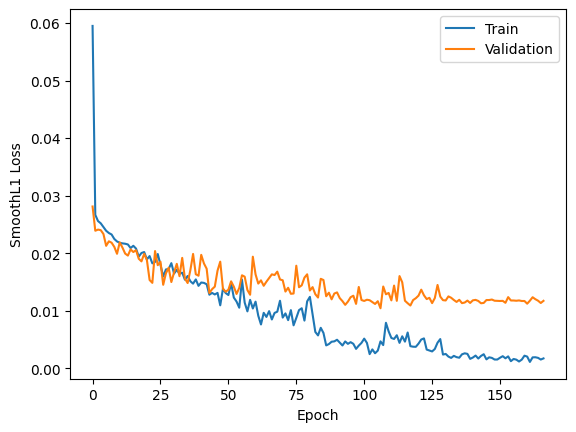

In [ ]:
import ast
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# ------------------------------- Load & filter -------------------------------
df = pd.read_csv("size_estimation_2Tx.csv")
df = df[df["method"] == "KMeans centers"].copy()
#df = df[df["method"] == "MCD-inlier density-weighted centers (on KMeans partitions)"].copy()

def to_vec3(x):
    if isinstance(x, list): return [float(x[0]), float(x[1]), float(x[2])]
    if isinstance(x, str):  return list(map(float, ast.literal_eval(x)))
    raise ValueError("Unexpected est_center type")

df["est_center"] = df["est_center"].apply(to_vec3)
df["est_size"]   = df["est_size"].astype(float)
df["true_size"]  = df["true_size"].astype(float)
df["tx_index"]   = df["tx_index"].astype(int)

# ------------------------------- Infer K and build multi-cluster rows -------------------------------
counts_per_file = df.groupby("file_index")["tx_index"].nunique()
K = int(counts_per_file.mode().iloc[0])
print(f"Detected K = {K} clusters per scene (using modal count).")

def has_all_k(s):
    return set(s["tx_index"].unique()) == set(range(K))

g = (df.groupby(["file_index"], as_index=False)
       .filter(has_all_k)
       .sort_values(["file_index", "tx_index"])
       .reset_index(drop=True))

rows = []
for fid, s in g.groupby("file_index"):
    s = s.sort_values("tx_index")
    if list(s["tx_index"]) != list(range(K)):
        continue
    feat = []
    target = []
    for k in range(K):
        feat.append(float(s.loc[s["tx_index"] == k, "est_size"].values[0]))
        feat.extend(list(map(float, s.loc[s["tx_index"] == k, "est_center"].values[0])))
        target.append(float(s.loc[s["tx_index"] == k, "true_size"].values[0]))
    rows.append({"file_index": int(fid), "X": feat, "y": target})

pairs = pd.DataFrame(rows)
print(f"Built {len(pairs)} training rows with K={K}.")

X_all = np.array(pairs["X"].to_list(), dtype=float)      # (N, 4*K)
y_all = np.array(pairs["y"].to_list(), dtype=float)      # (N, K)

# ------------------------------- Load consistent split -------------------------------
SPLIT_CSV = "train_val_test_split_2Tx.csv"   # produced by first script
split_df = pd.read_csv(SPLIT_CSV)
train_files = set(split_df.loc[split_df["split"] == "train", "file_index"].astype(int))
val_files   = set(split_df.loc[split_df["split"] == "validation", "file_index"].astype(int))
test_files  = set(split_df.loc[split_df["split"] == "test",  "file_index"].astype(int))

pairs["file_index"] = pairs["file_index"].astype(int)
pairs_train = pairs[pairs["file_index"].isin(train_files)].copy()
pairs_val   = pairs[pairs["file_index"].isin(val_files)].copy()
pairs_test  = pairs[pairs["file_index"].isin(test_files)].copy()

X_train = np.array(pairs_train["X"].to_list(), dtype=float)
y_train = np.array(pairs_train["y"].to_list(), dtype=float)
X_val   = np.array(pairs_val["X"].to_list(), dtype=float)
y_val   = np.array(pairs_val["y"].to_list(), dtype=float)
X_test  = np.array(pairs_test["X"].to_list(),  dtype=float)
y_test  = np.array(pairs_test["y"].to_list(),  dtype=float)
print(f"Reused split — train N={len(X_train)}, val N={len(X_val)}, test N={len(X_test)}")

# ------------------------------- Scaling -------------------------------
scaler_X_size = StandardScaler()
X_train_s = scaler_X_size.fit_transform(X_train)
X_val_s   = scaler_X_size.transform(X_val) 
X_test_s  = scaler_X_size.transform(X_test)

y_mean_size = y_train.mean(axis=0)
y_std_size  = y_train.std(axis=0); y_std_size[y_std_size==0] = 1.0
y_train_s = (y_train - y_mean_size) / y_std_size
y_val_s   = (y_val - y_mean_size) / y_std_size
y_test_s  = (y_test  - y_mean_size) / y_std_size

# ------------------------------- Dataset -------------------------------
class MultiKDataset(Dataset):
    def __init__(self, Xs, ys, K, permute_prob=0.5, train=True):
        self.Xs = np.ascontiguousarray(Xs, dtype=np.float32)
        self.ys = np.ascontiguousarray(ys, dtype=np.float32)
        self.K = int(K)
        self.permute_prob = float(permute_prob)
        self.train = bool(train)

    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx].copy()
        y = self.ys[idx].copy()
        if self.train and np.random.rand() < self.permute_prob:
            perm = np.random.permutation(self.K)
            x = x.reshape(self.K, 4)[perm].reshape(-1)
            y = y[perm]
        return torch.from_numpy(x), torch.from_numpy(y)

train_ds = MultiKDataset(X_train_s, y_train_s, K=K, permute_prob=0.5, train=True)
val_ds   = MultiKDataset(X_val_s,   y_val_s,   K=K, permute_prob=0.0, train=False)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)

# ------------------------------- Residual MLP -------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, dim, p_drop=0.1, use_bn=False):
        super().__init__()
        layers = [nn.Linear(dim, dim), nn.ReLU()]
        if use_bn:
            layers.append(nn.BatchNorm1d(dim))
        layers += [nn.Linear(dim, dim)]
        self.net = nn.Sequential(*layers)
        self.dropout = nn.Dropout(p_drop) if p_drop > 0 else nn.Identity()
    def forward(self, x):
        return x + self.dropout(self.net(x))

class ResidualMLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=256, depth=6, p_drop=0.1, use_bn=False):
        super().__init__()
        self.stem = nn.Sequential(nn.Linear(in_dim, hidden_dim), nn.ReLU())
        self.blocks = nn.Sequential(*[ResidualBlock(hidden_dim, p_drop=p_drop, use_bn=use_bn) for _ in range(depth)])
        self.head = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim)
        )
    def forward(self, x):
        return self.head(self.blocks(self.stem(x)))

in_dim = 4 * K
out_dim = K
size = ResidualMLP(in_dim=in_dim, out_dim=out_dim, hidden_dim=256, depth=6, p_drop=0.1)

# ------------------------------- Optim & training -------------------------------
opt = torch.optim.Adam(size.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.SmoothL1Loss(beta=1.0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=20)

best_val, best_state, bad, patience = float("inf"), None, 0, 60
EPOCHS = 1000
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    size.train(); running = 0.0
    for xb, yb in train_loader:
        pred = size(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        running += loss.item() * xb.size(0)
    train_loss = running / len(train_ds)

    size.eval(); val_running = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = size(xb)
            val_running += loss_fn(pred, yb).item() * xb.size(0)
    val_loss = val_running / len(val_ds)
    scheduler.step(val_loss)

    train_losses.append(train_loss); val_losses.append(val_loss)
    if val_loss < best_val - 1e-6:
        best_val, bad = val_loss, 0
        best_state = {k: v.detach().cpu().clone() for k, v in size.state_dict().items()}
    else:
        bad += 1
    if epoch % 50 == 0:
        print(f"Epoch {epoch:3d} | Train {train_loss:.6f} | Val {val_loss:.6f} | LR {opt.param_groups[0]['lr']:.2e}")
    if bad >= patience:
        print(f"Early stopping at epoch {epoch}"); break

if best_state is not None:
    size.load_state_dict(best_state)

# ------------------------------- Predict & evaluate -------------------------------
size.eval()
with torch.no_grad():
    y_pred_s = size(torch.from_numpy(X_test_s.astype(np.float32))).numpy()
y_pred = y_pred_s * y_std_size + y_mean_size

baseline_cols = [4*k for k in range(K)]
baseline = X_test[:, baseline_cols]

rmse_per_cluster_model, rmse_per_cluster_base = [], []
for k in range(K):
    rmse_per_cluster_model.append(float(np.sqrt(mean_squared_error(y_test[:,k], y_pred[:,k]))))
    rmse_per_cluster_base.append(float(np.sqrt(mean_squared_error(y_test[:,k], baseline[:,k]))))

rmse_overall_model = float(np.sqrt(mean_squared_error(y_test.reshape(-1), y_pred.reshape(-1))))
rmse_overall_base  = float(np.sqrt(mean_squared_error(y_test.reshape(-1), baseline.reshape(-1))))

for k in range(K):
    delta = rmse_per_cluster_base[k] - rmse_per_cluster_model[k]
    print(f"RMSE TX{k} — ANN: {rmse_per_cluster_model[k]:.4f}   RAW: {rmse_per_cluster_base[k]:.4f}   Δ={delta:.4f}")
print(f"RMSE Overall — ANN: {rmse_overall_model:.4f}   RAW: {rmse_overall_base:.4f}   Δ={rmse_overall_base - rmse_overall_model:.4f}")
print(f"Best Val Loss (scaled SmoothL1): {best_val:.6f}")

# ------------------------------- MAPE -------------------------------
eps = 1e-6
for k in range(K):
    mape_k = float(np.mean(np.abs((y_test[:,k] - y_pred[:,k]) / np.clip(np.abs(y_test[:,k]), eps, None))))
    print(f"MAPE TX{k} — ANN: {mape_k*100:.2f}%")
mape_overall = float(np.mean(np.abs((y_test - y_pred) / np.clip(np.abs(y_test), eps, None))))
print(f"MAPE Overall — ANN: {mape_overall*100:.2f}%")

# ------------------------------- Save artifacts -------------------------------
globals()["scaler_X_size"] = scaler_X_size
globals()["y_mean_size"] = y_mean_size
globals()["y_std_size"]  = y_std_size
globals()["size"] = size
globals()["K"] = K

# ------------------------------- Plot losses -------------------------------
try:
    import matplotlib.pyplot as plt
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epoch"); plt.ylabel("SmoothL1 Loss")
    plt.legend(); plt.show()
except Exception:
    pass


# ErfC Inversion

In [ ]:
# --------------- STEP-BY-STEP COMPARISON PIPELINE ---------------
# 1) Evaluate RAW with est_center_i & est_size_i
# 2) Build features and feed models (size & angle)
# 3) Obtain predicted results (counts & directions)
# 4) Evaluate SIZE-ONLY, ANGLE-ONLY, ANGLE+SIZE
#
# This version generalizes to ANY number of clusters K.
# - Features per scene: [size_k, cx_k, cy_k, cz_k] for k=0..K-1  -> 4*K dims
# - Size model output: K counts (per cluster)
# - Angle model output: 3*K vectors (per cluster), turned into unit directions

import ast
import numpy as np
import pandas as pd
import torch
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from scipy.special import erfc
from scipy.optimize import brentq

# ====================== Config ======================
#METHOD = "Density-weighted centers (on KMeans partitions)"  # change/loop as needed
METHOD = "KMeans centers"
#METHOD = "MCD-inlier density-weighted centers (on KMeans partitions)"
CFG_PATH = "./uniform_test/config.csv"
DF_PATH  = "size_estimation_2Tx.csv"
SPLIT_CSV = "train_val_test_split_2Tx.csv"

N_EMITTED_PER_TX = 10000
R_R_FIXED = 5.0
D = 79.4
T_HORIZON = 1.0
F_EPS = 1e-12  # clamp for F in (0,1)

# Optional: register additional models if their variable names differ
MODEL_REGISTRY_SIZE = {
    # "size_v1": dict(model=size,  scaler=scaler_X_size,  y_mean=y_mean_size,  y_std=y_std_size),
    # "size_v2": dict(model=size2, scaler=scaler_X_size2, y_mean=y_mean_size2, y_std=y_std_size2),
}
MODEL_REGISTRY_ANGLE = {
    # "angle_v1": dict(model=model,  scaler=scaler_X,  y_mean=y_mean,  y_std=y_std),
    # "angle_v2": dict(model=model2, scaler=scaler_X2, y_mean=y_mean2, y_std=y_std2),
}

# ====================== Helpers ======================
def to_vec3(x):
    if isinstance(x, list): return [float(x[0]), float(x[1]), float(x[2])]
    if isinstance(x, str):  return list(map(float, ast.literal_eval(x)))
    raise ValueError("Unexpected 3D vector type")

def unit_vec(v, eps=1e-12):
    v = np.asarray(v, dtype=float)
    n = float(np.linalg.norm(v))
    if not np.isfinite(n) or n < eps:
        return np.full(3, np.nan)
    return v / n

def vector_rmse(a, b):
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    return float(np.sqrt(np.mean((a - b) ** 2))) if len(a) and len(b) else np.nan

def vector_mape(a, b, eps=1e-12):
    """
    Mean Absolute Percentage Error for 3D positions (in %).
    Uses relative Euclidean error: ||est-true|| / ||true||.
    Pairs with ||true|| <= eps are ignored.
    """
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    if a.size == 0 or b.size == 0:
        return np.nan
    A = a.reshape(-1, 3); B = b.reshape(-1, 3)
    denom = np.linalg.norm(B, axis=1)
    numer = np.linalg.norm(A - B, axis=1)
    mask = denom > eps
    if not np.any(mask):
        return np.nan
    return float(100.0 * np.mean(numer[mask] / denom[mask]))

def invert_r0_from_fraction(F_hit, r_r, D, t, r0_min=None, r0_max=30):
    """Solve F = (r_r / r0) * erfc((r0-r_r)/sqrt(4Dt)) for r0; robust with clamp & bracket expansion."""
    if not np.isfinite(F_hit):
        return np.nan
    # Keep F within open interval (0,1) for a well-posed inverse
    F_hit = float(np.clip(F_hit, F_EPS, 1.0 - F_EPS))

    rr = float(r_r)
    eps = 1e-9
    a = rr + eps if r0_min is None else max(rr + eps, float(r0_min))  # physically r0 > r_r
    b = float(r0_max)

    def func(r0):
        return (rr / r0) * erfc((r0 - rr) / np.sqrt(4.0 * D * t)) - F_hit

    fa, fb = func(a), func(b)
    tries = 0
    # Expand the upper bracket if needed
    while np.isfinite(fa) and np.isfinite(fb) and fa * fb > 0 and tries < 100:
        b *= 2.0
        fb = func(b)
        tries += 1

    if not (np.isfinite(fa) and np.isfinite(fb)) or fa * fb > 0:
        return np.nan

    try:
        return float(brentq(func, a, b, maxiter=10000))
    except Exception:
        return np.nan

def estimate_tx_from_cluster_r0(center_vec, n_received, N_emitted, D, t, r_r=5.0, rx_center=np.array([0.0,0.0,0.0])):
    """
    Invert r0 from F = n_received / N_emitted, then place along direction(center_vec).
    If n_received > N_emitted, estimate r0 = r_r directly (saturated case).
    """
    # ---- Direction from receiver to measured cluster center ----
    center_vec = np.asarray(center_vec, dtype=float)
    rx_center  = np.asarray(rx_center,  dtype=float)
    v = center_vec - rx_center
    nv = np.linalg.norm(v)
    if nv < 1e-12:
        return np.array([np.nan, np.nan, np.nan]), np.nan, np.nan
    u = v / nv

    # ---- Validate counts ----
    if not (np.isfinite(n_received) and np.isfinite(N_emitted) and N_emitted > 0):
        return np.array([np.nan, np.nan, np.nan]), np.nan, np.nan

    # ---- Saturation rule: more received than emitted -> r0 := r_r ----
    if n_received > N_emitted:
        r0 = float(r_r)
        F_used = 1.0  # saturated fraction
        tx_est = rx_center + r0 * u
        return tx_est, r0, F_used

    # ---- Regular path ----
    # Clip to [1, N_emitted-1] to stay inside (0,1) after division
    n_recv_clip = int(np.clip(int(round(float(n_received))), 1, int(N_emITTED_PER_TX := N_emitted) - 1))
    F = float(n_recv_clip) / float(N_emitted)
    F = float(np.clip(F, F_EPS, 1.0 - F_EPS))

    r0 = invert_r0_from_fraction(F, r_r, D, t)
    tx_est = rx_center + r0 * u if np.isfinite(r0) else np.array([0.0, 0.0, 0.0]) * np.nan
    return tx_est, r0, F

# ====================== Load data & build K-general pairs ======================
df = pd.read_csv(DF_PATH)
df = df[df["method"] == METHOD].copy()
df["est_center"] = df["est_center"].apply(to_vec3)
df["est_size"]   = df["est_size"].astype(float)
df["tx_index"]   = df["tx_index"].astype(int)

cfg = pd.read_csv(CFG_PATH)
if "file_index" not in cfg.columns:
    cfg = cfg.reset_index().rename(columns={"index":"file_index"})

# Build truth map and infer K (must be consistent across scenes)
truth_map = {}
K = None
for _, r in cfg.iterrows():
    centers = r["tx_centers"]
    centers = ast.literal_eval(centers) if isinstance(centers, str) else centers
    centers = np.asarray([list(map(float, c)) for c in centers], dtype=float)
    truth_map[int(r["file_index"])] = centers
    if K is None:
        K = centers.shape[0]
    else:
        assert K == centers.shape[0], f"Inconsistent K across files: got {centers.shape[0]} vs {K}"

print(f"Detected K = {K} clusters per scene.")

# Keep only scenes present in truth and having all tx_index {0..K-1}
df = df[df["file_index"].isin(truth_map.keys())]

def has_all_k(s):
    return set(s["tx_index"].unique()) == set(range(K))

g = (df.groupby(["file_index"], as_index=False)
       .filter(has_all_k)
       .sort_values(["file_index","tx_index"])
       .reset_index(drop=True))

# Build a compact "pairs" DataFrame with arrays per scene
rows = []
for fid, s in g.groupby("file_index"):
    s = s.sort_values("tx_index")
    if list(s["tx_index"]) != list(range(K)):
        continue
    est_sizes = s["est_size"].astype(float).to_numpy()                  # (K,)
    est_centers = np.vstack(s["est_center"].tolist()).astype(float)     # (K,3)
    rows.append({"file_index": int(fid), "est_sizes": est_sizes, "est_centers": est_centers})

pairs = pd.DataFrame(rows)
if len(pairs) == 0:
    raise ValueError(f"No complete scenes with K={K} for method '{METHOD}'.")
print(f"Prepared {len(pairs)} scenes (pre-split).")

# ====================== TEST SPLIT FILTER ======================
split_df = pd.read_csv(SPLIT_CSV)
test_files = set(split_df.loc[split_df["split"].str.lower() == "test", "file_index"].astype(int))
pairs = (pairs[pairs["file_index"].isin(test_files)]
         .sort_values("file_index").reset_index(drop=True))
if len(pairs) == 0:
    raise ValueError("No test scenes after filtering by split CSV.")
print(f"Using TEST set only — scenes: {len(pairs)}")

# ====================== Step 1 — Evaluate RAW ======================
raw_est, raw_true = [], []
raw_skipped = 0
for _, r in pairs.iterrows():
    T = np.asarray(truth_map[int(r["file_index"])], dtype=float)  # (K,3)
    E = []
    for k in range(K):
        c_vec = r["est_centers"][k]
        n_recv = r["est_sizes"][k]
        tx, _, _ = estimate_tx_from_cluster_r0(
            center_vec=c_vec, n_received=float(n_recv),
            N_emitted=N_EMITTED_PER_TX, D=D, t=T_HORIZON,
            r_r=R_R_FIXED, rx_center=np.array([0.,0.,0.])
        )
        E.append(tx)
    E = np.asarray(E, dtype=float)  # (K,3)
    if not (np.all(np.isfinite(E)) and np.all(np.isfinite(T)) and E.shape==(K,3) and T.shape==(K,3)):
        raw_skipped += 1
        continue
    cost = cdist(E, T, metric="euclidean")
    r_ind, c_ind = linear_sum_assignment(cost)
    raw_est.extend(E[r_ind]); raw_true.extend(T[c_ind])

rmse_raw = vector_rmse(raw_est, raw_true)
mape_raw = vector_mape(raw_est, raw_true)
print(f"Step 1 — RAW | RMSE: {rmse_raw:.6f} | MAPE: {mape_raw:.3f}% | matches: {len(raw_est)} | skipped scenes: {raw_skipped}")

# ====================== Step 2 — Build features & discover models ======================
def row_to_feat(r):
    # Flatten blocks of 4 per cluster: [size_k, cx_k, cy_k, cz_k] for k=0..K-1
    feat = []
    for k in range(K):
        feat.append(float(r["est_sizes"][k]))
        feat.extend(list(map(float, r["est_centers"][k])))
    return feat

X4K = np.array([row_to_feat(r) for _, r in pairs.iterrows()], dtype=float)  # (N, 4*K)

# Discover models in memory (or use registries filled above)
def try_add_size_model(reg, name, model_name, scaler_name, mean_name, std_name, globs):
    if all(k in globs for k in [model_name, scaler_name, mean_name, std_name]):
        reg[name] = dict(model=globs[model_name], scaler=globs[scaler_name],
                         y_mean=globs[mean_name], y_std=globs[std_name])

def try_add_angle_model(reg, name, model_name, scaler_name, mean_name, std_name, globs):
    if all(k in globs for k in [model_name, scaler_name, mean_name, std_name]):
        reg[name] = dict(model=globs[model_name], scaler=globs[scaler_name],
                         y_mean=globs[mean_name], y_std=globs[std_name])

size_models = dict(MODEL_REGISTRY_SIZE)
angle_models = dict(MODEL_REGISTRY_ANGLE)
G = globals()
try_add_size_model(size_models,  "size_v1", "size",  "scaler_X_size",  "y_mean_size",  "y_std_size",  G)
try_add_size_model(size_models,  "size_v2", "size2", "scaler_X_size2", "y_mean_size2", "y_std_size2", G)
try_add_angle_model(angle_models,"angle_v1","model", "scaler_X",       "y_mean",       "y_std",       G)
try_add_angle_model(angle_models,"angle_v2","model2","scaler_X2",      "y_mean2",      "y_std2",      G)

print(f"Step 2 — Models found | size: {list(size_models.keys()) or '(none)'} | angle: {list(angle_models.keys()) or '(none)'}")

# ====================== Step 3 — Predict (size counts & angle directions) ======================
def predict_sizes(X, spec, K_expected):
    mdl, scl, ym, ys = spec["model"], spec["scaler"], spec["y_mean"], spec["y_std"]
    Xs = scl.transform(X)
    with torch.no_grad():
        y_s = mdl(torch.tensor(Xs, dtype=torch.float32)).cpu().numpy()  # (N, K_m)
    y = y_s * ys + ym  # de-standardize
    # Guard against mismatched K
    if y.shape[1] != K_expected:
        print(f"[WARN] Skipping size model (out_dim={y.shape[1]} != K={K_expected}).")
        return None
    # Return floats; downstream estimator clamps to physical range
    return np.clip(y.astype(float), 1.0, float(N_EMITTED_PER_TX))

def predict_angles(X, spec, K_expected):
    mdl, scl, ym, ys = spec["model"], spec["scaler"], spec["y_mean"], spec["y_std"]
    Xs = scl.transform(X)
    with torch.no_grad():
        y_s = mdl(torch.tensor(Xs, dtype=torch.float32)).cpu().numpy()  # (N, 3*K_m)
    y = y_s * ys + ym
    if y.shape[1] % 3 != 0:
        print(f"[WARN] Angle model output dim {y.shape[1]} not divisible by 3; skipping.")
        return None
    K_m = y.shape[1] // 3
    if K_m != K_expected:
        print(f"[WARN] Skipping angle model (K_out={K_m} != K={K_expected}).")
        return None
    # Convert to unit directions (N, K, 3)
    y = y.reshape(y.shape[0], K_m, 3)
    dirs = np.zeros_like(y)
    for i in range(y.shape[0]):
        for k in range(K_m):
            dirs[i, k] = unit_vec(y[i, k])
    return dirs  # (N, K, 3)

size_preds = {}
for name, spec in size_models.items():
    pred = predict_sizes(X4K, spec, K_expected=K)
    if pred is not None:
        size_preds[name] = pred

angle_preds = {}
for name, spec in angle_models.items():
    pred = predict_angles(X4K, spec, K_expected=K)
    if pred is not None:
        angle_preds[name] = pred

print("Step 3 — Predictions obtained.")

# ====================== Step 4 — Evaluate predicted variants ======================
results = []

# SIZE-ONLY (use raw dirs via est_centers, predicted counts)
for name_sz, y_counts in size_preds.items():
    est, tru = [], []
    skipped = 0
    for j, (_, r) in enumerate(pairs.iterrows()):
        T = np.asarray(truth_map[int(r["file_index"])], dtype=float)  # (K,3)
        E = []
        for k in range(K):
            tx, _, _ = estimate_tx_from_cluster_r0(
                center_vec=r["est_centers"][k],
                n_received=float(y_counts[j, k]),  # positional index!
                N_emitted=N_EMITTED_PER_TX, D=D, t=T_HORIZON,
                r_r=R_R_FIXED, rx_center=np.array([0.,0.,0.])
            )
            E.append(tx)
        E = np.asarray(E, dtype=float)  # (K,3)
        if not (np.all(np.isfinite(E)) and np.all(np.isfinite(T))):
            skipped += 1
            continue
        cost = cdist(E, T, metric="euclidean")
        r_ind, c_ind = linear_sum_assignment(cost)
        est.extend(E[r_ind]); tru.extend(T[c_ind])
    rmse = vector_rmse(est, tru)
    mape = vector_mape(est, tru)
    print(f"Step 4 — SIZE-ONLY[{name_sz}] | RMSE: {rmse:.6f} | MAPE: {mape:.3f}% | matches: {len(est)} | skipped scenes: {skipped}")
    results.append(dict(variant="SIZE-ONLY", model=name_sz, rmse=rmse, mape=mape, matches=len(est)))

# ANGLE-ONLY (use predicted dirs, observed counts to set radii via estimate_tx_from_cluster_r0)
for name_ang, dirs in angle_preds.items():
    est, tru = [], []
    skipped = 0

    for j, (_, r) in enumerate(pairs.iterrows()):
        T = np.asarray(truth_map[int(r["file_index"])], dtype=float)  # (K,3)
        if T.shape[0] != K or not np.all(np.isfinite(T)):
            skipped += 1
            continue

        tx_estimates = []
        ok = True

        for k in range(K):
            # direction for this cluster (ensure unit length)
            dir_k = np.asarray(dirs[j][k], dtype=float)
            n = np.linalg.norm(dir_k)
            if not np.isfinite(n) or n < 1e-12:
                ok = False
                break
            dir_k = dir_k / n

            # observed count for this cluster
            n_recv = float(r["est_sizes"][k])

            # estimate tx position along dir_k based on r0 inversion
            tx_est, r0, F_used = estimate_tx_from_cluster_r0(
                center_vec=dir_k,                 # just a direction; function normalizes anyway
                n_received=n_recv,
                N_emitted=N_EMITTED_PER_TX,
                D=D,
                t=T_HORIZON,
                r_r=R_R_FIXED,
                rx_center=np.array([0.0, 0.0, 0.0])  # receiver at origin
            )

            if not np.all(np.isfinite(tx_est)):
                ok = False
                break

            tx_estimates.append(tx_est)

        if not ok:
            skipped += 1
            continue

        E = np.vstack(tx_estimates)  # (K,3)
        cost = cdist(E, T, metric="euclidean")
        r_ind, c_ind = linear_sum_assignment(cost)
        est.extend(E[r_ind]); tru.extend(T[c_ind])

    rmse = vector_rmse(est, tru)
    mape = vector_mape(est, tru)
    print(f"Step 4 — ANGLE-ONLY[{name_ang}] | RMSE: {rmse:.6f} | MAPE: {mape:.3f}% | matches: {len(est)} | skipped scenes: {skipped}")
    results.append(dict(variant="ANGLE-ONLY", model=name_ang, rmse=rmse, mape=mape, matches=len(est)))

# ANGLE+SIZE (use predicted dirs and predicted counts via r0 inversion)
for name_ang, dirs in angle_preds.items():
    for name_sz, y_counts in size_preds.items():
        est, tru = [], []
        skipped = 0

        for j, (_, r) in enumerate(pairs.iterrows()):
            T = np.asarray(truth_map[int(r["file_index"])], dtype=float)  # (K,3)
            if T.shape[0] != K or not np.all(np.isfinite(T)):
                skipped += 1
                continue

            tx_estimates = []
            ok = True

            for k in range(K):
                # direction for this cluster -> ensure unit vector
                dir_k = np.asarray(dirs[j][k], dtype=float)
                nrm = np.linalg.norm(dir_k)
                if not np.isfinite(nrm) or nrm < 1e-12:
                    ok = False
                    break
                dir_k = dir_k / nrm

                # predicted count for this cluster (float; function will clamp)
                n_recv = float(y_counts[j, k])

                # estimate tx position along dir_k based on r0 inversion
                tx_est, r0, F_used = estimate_tx_from_cluster_r0(
                    center_vec=dir_k,                 # direction is enough; function normalizes again
                    n_received=n_recv,
                    N_emitted=N_EMITTED_PER_TX,
                    D=D,
                    t=T_HORIZON,
                    r_r=R_R_FIXED,
                    rx_center=np.array([0.0, 0.0, 0.0])  # receiver at origin
                )

                if not np.all(np.isfinite(tx_est)):
                    ok = False
                    break

                tx_estimates.append(tx_est)

            if not ok:
                skipped += 1
                continue

            E = np.vstack(tx_estimates)  # (K,3)
            cost = cdist(E, T, metric="euclidean")
            r_ind, c_ind = linear_sum_assignment(cost)
            est.extend(E[r_ind]); tru.extend(T[c_ind])

        rmse = vector_rmse(est, tru)
        mape = vector_mape(est, tru)
        print(f"Step 4 — ANGLE+SIZE[{name_ang}×{name_sz}] | RMSE: {rmse:.6f} | MAPE: {mape:.3f}% | matches: {len(est)} | skipped scenes: {skipped}")
        results.append(dict(variant="ANGLE+SIZE", model=f"{name_ang} × {name_sz}",
                            rmse=rmse, mape=mape, matches=len(est)))

# ====================== Summary & Save ======================
summary = [dict(variant="RAW", model="", rmse=rmse_raw, mape=mape_raw, matches=len(raw_est))]
summary.extend(results)
res_df = pd.DataFrame(summary).sort_values(["variant","model"]).reset_index(drop=True)
print("\n=== Summary (TEST only) ===")
print(res_df.to_string(index=False))

out_csv = "inversion_comparison_step_by_step_2Tx_TEST.csv"
res_df.to_csv(out_csv, index=False)
print(f"\nSaved: {out_csv}")


Detected K = 2 clusters per scene.
Prepared 10000 scenes (pre-split).
Using TEST set only — scenes: 2000
Step 1 — RAW | RMSE: 1.213374 | MAPE: 12.861% | matches: 4000 | skipped scenes: 0
Step 2 — Models found | size: ['size_v1'] | angle: ['angle_v1']
Step 3 — Predictions obtained.
Step 4 — SIZE-ONLY[size_v1] | RMSE: 1.175519 | MAPE: 12.421% | matches: 4000 | skipped scenes: 0
Step 4 — ANGLE-ONLY[angle_v1] | RMSE: 0.441286 | MAPE: 5.056% | matches: 4000 | skipped scenes: 0
Step 4 — ANGLE+SIZE[angle_v1×size_v1] | RMSE: 0.358540 | MAPE: 3.987% | matches: 4000 | skipped scenes: 0

=== Summary (TEST only) ===
   variant              model     rmse      mape  matches
ANGLE+SIZE angle_v1 × size_v1 0.358540  3.986749     4000
ANGLE-ONLY           angle_v1 0.441286  5.056171     4000
       RAW                    1.213374 12.860955     4000
 SIZE-ONLY            size_v1 1.175519 12.420865     4000

Saved: inversion_comparison_step_by_step_2Tx_TEST.csv


In [ ]:
# --------------- STEP-BY-STEP COMPARISON PIPELINE ---------------
# 1) Evaluate RAW with est_center_i & est_size_i
# 2) Build features and feed models (size & angle)
# 3) Obtain predicted results (counts & directions)
# 4) Evaluate SIZE-ONLY, ANGLE-ONLY, ANGLE+SIZE
#
# This version generalizes to ANY number of clusters K.
# - Features per scene: [size_k, cx_k, cy_k, cz_k] for k=0..K-1  -> 4*K dims
# - Size model output: K counts (per cluster)
# - Angle model output: 3*K vectors (per cluster), turned into unit directions

import ast
import numpy as np
import pandas as pd
import torch
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from scipy.special import erfc
from scipy.optimize import brentq

# ====================== Config ======================
#METHOD = "Density-weighted centers (on KMeans partitions)"  # change/loop as needed
METHOD = "KMeans centers"
#METHOD = "MCD-inlier density-weighted centers (on KMeans partitions)"
CFG_PATH = "./uniform_test/config.csv"
DF_PATH  = "size_estimation_2Tx.csv"
SPLIT_CSV = "train_val_test_split_2Tx.csv"

N_EMITTED_PER_TX = 10000
R_R_FIXED = 5.0
D = 79.4
T_HORIZON = 1.0
F_EPS = 1e-12  # clamp for F in (0,1)

# Optional: register additional models if their variable names differ
MODEL_REGISTRY_SIZE = {
    # "size_v1": dict(model=size,  scaler=scaler_X_size,  y_mean=y_mean_size,  y_std=y_std_size),
    # "size_v2": dict(model=size2, scaler=scaler_X_size2, y_mean=y_mean_size2, y_std=y_std_size2),
}
MODEL_REGISTRY_ANGLE = {
    # "angle_v1": dict(model=model,  scaler=scaler_X,  y_mean=y_mean,  y_std=y_std),
    # "angle_v2": dict(model=model2, scaler=scaler_X2, y_mean=y_mean2, y_std=y_std2),
}

# ====================== Helpers ======================
def to_vec3(x):
    if isinstance(x, list): return [float(x[0]), float(x[1]), float(x[2])]
    if isinstance(x, str):  return list(map(float, ast.literal_eval(x)))
    raise ValueError("Unexpected 3D vector type")

def unit_vec(v, eps=1e-12):
    v = np.asarray(v, dtype=float)
    n = float(np.linalg.norm(v))
    if not np.isfinite(n) or n < eps:
        return np.full(3, np.nan)
    return v / n

def vector_rmse(a, b):
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    return float(np.sqrt(np.mean((a - b) ** 2))) if len(a) and len(b) else np.nan

def vector_mape(a, b, eps=1e-12):
    """
    Mean Absolute Percentage Error for 3D positions (in %).
    Uses relative Euclidean error: ||est-true|| / ||true||.
    Pairs with ||true|| <= eps are ignored.
    """
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    if a.size == 0 or b.size == 0:
        return np.nan
    A = a.reshape(-1, 3); B = b.reshape(-1, 3)
    denom = np.linalg.norm(B, axis=1)
    numer = np.linalg.norm(A - B, axis=1)
    mask = denom > eps
    if not np.any(mask):
        return np.nan
    return float(100.0 * np.mean(numer[mask] / denom[mask]))

def invert_r0_from_fraction(F_hit, r_r, D, t, r0_min=None, r0_max=30):
    """Solve F = (r_r / r0) * erfc((r0-r_r)/sqrt(4Dt)) for r0; robust with clamp & bracket expansion."""
    if not np.isfinite(F_hit):
        return np.nan
    # Keep F within open interval (0,1) for a well-posed inverse
    F_hit = float(np.clip(F_hit, F_EPS, 1.0 - F_EPS))

    rr = float(r_r)
    eps = 1e-9
    a = rr + eps if r0_min is None else max(rr + eps, float(r0_min))  # physically r0 > r_r
    b = float(r0_max)

    def func(r0):
        return (rr / r0) * erfc((r0 - rr) / np.sqrt(4.0 * D * t)) - F_hit

    fa, fb = func(a), func(b)
    tries = 0
    # Expand the upper bracket if needed
    while np.isfinite(fa) and np.isfinite(fb) and fa * fb > 0 and tries < 100:
        b *= 2.0
        fb = func(b)
        tries += 1

    if not (np.isfinite(fa) and np.isfinite(fb)) or fa * fb > 0:
        return np.nan

    try:
        return float(brentq(func, a, b, maxiter=10000))
    except Exception:
        return np.nan

def estimate_tx_from_cluster_r0(center_vec, n_received, N_emitted, D, t, r_r=5.0, rx_center=np.array([0.0,0.0,0.0])):
    """
    Invert r0 from F = n_received / N_emitted, then place along direction(center_vec).
    If n_received > N_emitted, estimate r0 = r_r directly (saturated case).
    """
    # ---- Direction from receiver to measured cluster center ----
    center_vec = np.asarray(center_vec, dtype=float)
    rx_center  = np.asarray(rx_center,  dtype=float)
    v = center_vec - rx_center
    nv = np.linalg.norm(v)
    if nv < 1e-12:
        return np.array([np.nan, np.nan, np.nan]), np.nan, np.nan
    u = v / nv

    # ---- Validate counts ----
    if not (np.isfinite(n_received) and np.isfinite(N_emitted) and N_emitted > 0):
        return np.array([np.nan, np.nan, np.nan]), np.nan, np.nan

    # ---- Saturation rule: more received than emitted -> r0 := r_r ----
    if n_received > N_emitted:
        r0 = float(r_r)
        F_used = 1.0  # saturated fraction
        tx_est = rx_center + r0 * u
        return tx_est, r0, F_used

    # ---- Regular path ----
    # Clip to [1, N_emitted-1] to stay inside (0,1) after division
    n_recv_clip = int(np.clip(int(round(float(n_received))), 1, int(N_emITTED_PER_TX := N_emitted) - 1))
    F = float(n_recv_clip) / float(N_emitted)
    F = float(np.clip(F, F_EPS, 1.0 - F_EPS))

    r0 = invert_r0_from_fraction(F, r_r, D, t)
    tx_est = rx_center + r0 * u if np.isfinite(r0) else np.array([0.0, 0.0, 0.0]) * np.nan
    return tx_est, r0, F

# ====================== Load data & build K-general pairs ======================
df = pd.read_csv(DF_PATH)
df = df[df["method"] == METHOD].copy()
df["est_center"] = df["est_center"].apply(to_vec3)
df["est_size"]   = df["est_size"].astype(float)
df["tx_index"]   = df["tx_index"].astype(int)

cfg = pd.read_csv(CFG_PATH)
if "file_index" not in cfg.columns:
    cfg = cfg.reset_index().rename(columns={"index":"file_index"})

# Build truth map and infer K (must be consistent across scenes)
truth_map = {}
K = None
for _, r in cfg.iterrows():
    centers = r["tx_centers"]
    centers = ast.literal_eval(centers) if isinstance(centers, str) else centers
    centers = np.asarray([list(map(float, c)) for c in centers], dtype=float)
    truth_map[int(r["file_index"])] = centers
    if K is None:
        K = centers.shape[0]
    else:
        assert K == centers.shape[0], f"Inconsistent K across files: got {centers.shape[0]} vs {K}"

print(f"Detected K = {K} clusters per scene.")

# Keep only scenes present in truth and having all tx_index {0..K-1}
df = df[df["file_index"].isin(truth_map.keys())]

def has_all_k(s):
    return set(s["tx_index"].unique()) == set(range(K))

g = (df.groupby(["file_index"], as_index=False)
       .filter(has_all_k)
       .sort_values(["file_index","tx_index"])
       .reset_index(drop=True))

# Build a compact "pairs" DataFrame with arrays per scene
rows = []
for fid, s in g.groupby("file_index"):
    s = s.sort_values("tx_index")
    if list(s["tx_index"]) != list(range(K)):
        continue
    est_sizes = s["est_size"].astype(float).to_numpy()                  # (K,)
    est_centers = np.vstack(s["est_center"].tolist()).astype(float)     # (K,3)
    rows.append({"file_index": int(fid), "est_sizes": est_sizes, "est_centers": est_centers})

pairs = pd.DataFrame(rows)
if len(pairs) == 0:
    raise ValueError(f"No complete scenes with K={K} for method '{METHOD}'.")
print(f"Prepared {len(pairs)} scenes (pre-split).")

# ====================== TEST SPLIT FILTER ======================
split_df = pd.read_csv(SPLIT_CSV)
test_files = set(split_df.loc[split_df["split"].str.lower() == "test", "file_index"].astype(int))
pairs = (pairs[pairs["file_index"].isin(test_files)]
         .sort_values("file_index").reset_index(drop=True))
if len(pairs) == 0:
    raise ValueError("No test scenes after filtering by split CSV.")
print(f"Using TEST set only — scenes: {len(pairs)}")

# ====================== Step 1 — Evaluate RAW ======================
raw_est, raw_true = [], []
raw_skipped = 0
for _, r in pairs.iterrows():
    T = np.asarray(truth_map[int(r["file_index"])], dtype=float)  # (K,3)
    E = []
    for k in range(K):
        c_vec = r["est_centers"][k]
        n_recv = r["est_sizes"][k]
        tx, _, _ = estimate_tx_from_cluster_r0(
            center_vec=c_vec, n_received=float(n_recv),
            N_emitted=N_EMITTED_PER_TX, D=D, t=T_HORIZON,
            r_r=R_R_FIXED, rx_center=np.array([0.,0.,0.])
        )
        E.append(tx)
    E = np.asarray(E, dtype=float)  # (K,3)
    if not (np.all(np.isfinite(E)) and np.all(np.isfinite(T)) and E.shape==(K,3) and T.shape==(K,3)):
        raw_skipped += 1
        continue
    cost = cdist(E, T, metric="euclidean")
    r_ind, c_ind = linear_sum_assignment(cost)
    raw_est.extend(E[r_ind]); raw_true.extend(T[c_ind])

rmse_raw = vector_rmse(raw_est, raw_true)
mape_raw = vector_mape(raw_est, raw_true)
print(f"Step 1 — RAW | RMSE: {rmse_raw:.6f} | MAPE: {mape_raw:.3f}% | matches: {len(raw_est)} | skipped scenes: {raw_skipped}")

# ====================== Step 2 — Build features & discover models ======================
def row_to_feat(r):
    # Flatten blocks of 4 per cluster: [size_k, cx_k, cy_k, cz_k] for k=0..K-1
    feat = []
    for k in range(K):
        feat.append(float(r["est_sizes"][k]))
        feat.extend(list(map(float, r["est_centers"][k])))
    return feat

X4K = np.array([row_to_feat(r) for _, r in pairs.iterrows()], dtype=float)  # (N, 4*K)

# Discover models in memory (or use registries filled above)
def try_add_size_model(reg, name, model_name, scaler_name, mean_name, std_name, globs):
    if all(k in globs for k in [model_name, scaler_name, mean_name, std_name]):
        reg[name] = dict(model=globs[model_name], scaler=globs[scaler_name],
                         y_mean=globs[mean_name], y_std=globs[std_name])

def try_add_angle_model(reg, name, model_name, scaler_name, mean_name, std_name, globs):
    if all(k in globs for k in [model_name, scaler_name, mean_name, std_name]):
        reg[name] = dict(model=globs[model_name], scaler=globs[scaler_name],
                         y_mean=globs[mean_name], y_std=globs[std_name])

size_models = dict(MODEL_REGISTRY_SIZE)
angle_models = dict(MODEL_REGISTRY_ANGLE)
G = globals()
try_add_size_model(size_models,  "size_v1", "size",  "scaler_X_size",  "y_mean_size",  "y_std_size",  G)
try_add_size_model(size_models,  "size_v2", "size2", "scaler_X_size2", "y_mean_size2", "y_std_size2", G)
try_add_angle_model(angle_models,"angle_v1","model", "scaler_X",       "y_mean",       "y_std",       G)
try_add_angle_model(angle_models,"angle_v2","model2","scaler_X2",      "y_mean2",      "y_std2",      G)

print(f"Step 2 — Models found | size: {list(size_models.keys()) or '(none)'} | angle: {list(angle_models.keys()) or '(none)'}")

# ====================== Step 3 — Predict (size counts & angle directions) ======================
def predict_sizes(X, spec, K_expected):
    mdl, scl, ym, ys = spec["model"], spec["scaler"], spec["y_mean"], spec["y_std"]
    Xs = scl.transform(X)
    with torch.no_grad():
        y_s = mdl(torch.tensor(Xs, dtype=torch.float32)).cpu().numpy()  # (N, K_m)
    y = y_s * ys + ym  # de-standardize
    # Guard against mismatched K
    if y.shape[1] != K_expected:
        print(f"[WARN] Skipping size model (out_dim={y.shape[1]} != K={K_expected}).")
        return None
    # Return floats; downstream estimator clamps to physical range
    return np.clip(y.astype(float), 1.0, float(N_EMITTED_PER_TX))

def predict_angles(X, spec, K_expected):
    mdl, scl, ym, ys = spec["model"], spec["scaler"], spec["y_mean"], spec["y_std"]
    Xs = scl.transform(X)
    with torch.no_grad():
        y_s = mdl(torch.tensor(Xs, dtype=torch.float32)).cpu().numpy()  # (N, 3*K_m)
    y = y_s * ys + ym
    if y.shape[1] % 3 != 0:
        print(f"[WARN] Angle model output dim {y.shape[1]} not divisible by 3; skipping.")
        return None
    K_m = y.shape[1] // 3
    if K_m != K_expected:
        print(f"[WARN] Skipping angle model (K_out={K_m} != K={K_expected}).")
        return None
    # Convert to unit directions (N, K, 3)
    y = y.reshape(y.shape[0], K_m, 3)
    dirs = np.zeros_like(y)
    for i in range(y.shape[0]):
        for k in range(K_m):
            dirs[i, k] = unit_vec(y[i, k])
    return dirs  # (N, K, 3)

size_preds = {}
for name, spec in size_models.items():
    pred = predict_sizes(X4K, spec, K_expected=K)
    if pred is not None:
        size_preds[name] = pred

angle_preds = {}
for name, spec in angle_models.items():
    pred = predict_angles(X4K, spec, K_expected=K)
    if pred is not None:
        angle_preds[name] = pred

print("Step 3 — Predictions obtained.")

# ====================== Step 4 — Evaluate predicted variants ======================
results = []

# SIZE-ONLY (use raw dirs via est_centers, predicted counts)
for name_sz, y_counts in size_preds.items():
    est, tru = [], []
    skipped = 0
    for j, (_, r) in enumerate(pairs.iterrows()):
        T = np.asarray(truth_map[int(r["file_index"])], dtype=float)  # (K,3)
        E = []
        for k in range(K):
            tx, _, _ = estimate_tx_from_cluster_r0(
                center_vec=r["est_centers"][k],
                n_received=float(y_counts[j, k]),  # positional index!
                N_emitted=N_EMITTED_PER_TX, D=D, t=T_HORIZON,
                r_r=R_R_FIXED, rx_center=np.array([0.,0.,0.])
            )
            E.append(tx)
        E = np.asarray(E, dtype=float)  # (K,3)
        if not (np.all(np.isfinite(E)) and np.all(np.isfinite(T))):
            skipped += 1
            continue
        cost = cdist(E, T, metric="euclidean")
        r_ind, c_ind = linear_sum_assignment(cost)
        est.extend(E[r_ind]); tru.extend(T[c_ind])
    rmse = vector_rmse(est, tru)
    mape = vector_mape(est, tru)
    print(f"Step 4 — SIZE-ONLY[{name_sz}] | RMSE: {rmse:.6f} | MAPE: {mape:.3f}% | matches: {len(est)} | skipped scenes: {skipped}")
    results.append(dict(variant="SIZE-ONLY", model=name_sz, rmse=rmse, mape=mape, matches=len(est)))

# ANGLE-ONLY (use predicted dirs, observed counts to set radii via estimate_tx_from_cluster_r0)
for name_ang, dirs in angle_preds.items():
    est, tru = [], []
    skipped = 0

    for j, (_, r) in enumerate(pairs.iterrows()):
        T = np.asarray(truth_map[int(r["file_index"])], dtype=float)  # (K,3)
        if T.shape[0] != K or not np.all(np.isfinite(T)):
            skipped += 1
            continue

        tx_estimates = []
        ok = True

        for k in range(K):
            # direction for this cluster (ensure unit length)
            dir_k = np.asarray(dirs[j][k], dtype=float)
            n = np.linalg.norm(dir_k)
            if not np.isfinite(n) or n < 1e-12:
                ok = False
                break
            dir_k = dir_k / n

            # observed count for this cluster
            n_recv = float(r["est_sizes"][k])

            # estimate tx position along dir_k based on r0 inversion
            tx_est, r0, F_used = estimate_tx_from_cluster_r0(
                center_vec=dir_k,                 # just a direction; function normalizes anyway
                n_received=n_recv,
                N_emitted=N_EMITTED_PER_TX,
                D=D,
                t=T_HORIZON,
                r_r=R_R_FIXED,
                rx_center=np.array([0.0, 0.0, 0.0])  # receiver at origin
            )

            if not np.all(np.isfinite(tx_est)):
                ok = False
                break

            tx_estimates.append(tx_est)

        if not ok:
            skipped += 1
            continue

        E = np.vstack(tx_estimates)  # (K,3)
        cost = cdist(E, T, metric="euclidean")
        r_ind, c_ind = linear_sum_assignment(cost)
        est.extend(E[r_ind]); tru.extend(T[c_ind])

    rmse = vector_rmse(est, tru)
    mape = vector_mape(est, tru)
    print(f"Step 4 — ANGLE-ONLY[{name_ang}] | RMSE: {rmse:.6f} | MAPE: {mape:.3f}% | matches: {len(est)} | skipped scenes: {skipped}")
    results.append(dict(variant="ANGLE-ONLY", model=name_ang, rmse=rmse, mape=mape, matches=len(est)))

# ANGLE+SIZE (use predicted dirs and predicted counts via r0 inversion)
for name_ang, dirs in angle_preds.items():
    for name_sz, y_counts in size_preds.items():
        est, tru = [], []
        skipped = 0

        for j, (_, r) in enumerate(pairs.iterrows()):
            T = np.asarray(truth_map[int(r["file_index"])], dtype=float)  # (K,3)
            if T.shape[0] != K or not np.all(np.isfinite(T)):
                skipped += 1
                continue

            tx_estimates = []
            ok = True

            for k in range(K):
                # direction for this cluster -> ensure unit vector
                dir_k = np.asarray(dirs[j][k], dtype=float)
                nrm = np.linalg.norm(dir_k)
                if not np.isfinite(nrm) or nrm < 1e-12:
                    ok = False
                    break
                dir_k = dir_k / nrm

                # predicted count for this cluster (float; function will clamp)
                n_recv = float(y_counts[j, k])

                # estimate tx position along dir_k based on r0 inversion
                tx_est, r0, F_used = estimate_tx_from_cluster_r0(
                    center_vec=dir_k,                 # direction is enough; function normalizes again
                    n_received=n_recv,
                    N_emitted=N_EMITTED_PER_TX,
                    D=D,
                    t=T_HORIZON,
                    r_r=R_R_FIXED,
                    rx_center=np.array([0.0, 0.0, 0.0])  # receiver at origin
                )

                if not np.all(np.isfinite(tx_est)):
                    ok = False
                    break

                tx_estimates.append(tx_est)

            if not ok:
                skipped += 1
                continue

            E = np.vstack(tx_estimates)  # (K,3)
            cost = cdist(E, T, metric="euclidean")
            r_ind, c_ind = linear_sum_assignment(cost)
            est.extend(E[r_ind]); tru.extend(T[c_ind])

        rmse = vector_rmse(est, tru)
        mape = vector_mape(est, tru)
        print(f"Step 4 — ANGLE+SIZE[{name_ang}×{name_sz}] | RMSE: {rmse:.6f} | MAPE: {mape:.3f}% | matches: {len(est)} | skipped scenes: {skipped}")
        results.append(dict(variant="ANGLE+SIZE", model=f"{name_ang} × {name_sz}",
                            rmse=rmse, mape=mape, matches=len(est)))

# ====================== Summary & Save ======================
summary = [dict(variant="RAW", model="", rmse=rmse_raw, mape=mape_raw, matches=len(raw_est))]
summary.extend(results)
res_df = pd.DataFrame(summary).sort_values(["variant","model"]).reset_index(drop=True)
print("\n=== Summary (TEST only) ===")
print(res_df.to_string(index=False))

out_csv = "inversion_comparison_step_by_step_2Tx_TEST.csv" 
res_df.to_csv(out_csv, index=False)
print(f"\nSaved: {out_csv}")

# ====================== EXTRA: RAW results for OTHER methods (TEST only) ======================
# This computes RAW (Step 1) for every other method present in DF_PATH and saves a separate CSV.
df_all = pd.read_csv(DF_PATH).copy()
df_all = df_all[df_all["file_index"].isin(truth_map.keys())]

# parse/clean needed columns
df_all["est_center"] = df_all["est_center"].apply(to_vec3)
df_all["est_size"]   = pd.to_numeric(df_all["est_size"], errors="coerce")
df_all["tx_index"]   = pd.to_numeric(df_all["tx_index"], errors="coerce").astype("Int64")

selected_methods = [
    "Density-weighted centers (on KMeans partitions)",
    "MCD-inlier density-weighted centers (on KMeans partitions)",
    "Robust (MinCovDet) centers (on KMeans partitions)",  
]
raw_rows = []
for meth in selected_methods:
    dm = df_all[df_all["method"] == meth].dropna(subset=["tx_index"]).copy()
    dm["tx_index"] = dm["tx_index"].astype(int)

    # ensure each file has all K clusters
    gm = (dm.groupby(["file_index"], as_index=False)
            .filter(has_all_k)
            .sort_values(["file_index","tx_index"])
            .reset_index(drop=True))

    # build pairs for this method
    rows_m = []
    for fid, s in gm.groupby("file_index"):
        s = s.sort_values("tx_index")
        if list(s["tx_index"]) != list(range(K)):
            continue
        est_sizes = s["est_size"].astype(float).to_numpy()
        est_centers = np.vstack(s["est_center"].tolist()).astype(float)
        rows_m.append({"file_index": int(fid), "est_sizes": est_sizes, "est_centers": est_centers})
    pairs_m = pd.DataFrame(rows_m)
    if len(pairs_m) == 0:
        print(f"[RAW-OTHER] {meth}: no complete scenes.")
        continue

    # TEST split filter
    pairs_m = pairs_m[pairs_m["file_index"].isin(test_files)].sort_values("file_index").reset_index(drop=True)
    if len(pairs_m) == 0:
        print(f"[RAW-OTHER] {meth}: no TEST scenes after split.")
        continue

    # Step 1 RAW for this method
    est_m, tru_m = [], []
    skipped_m = 0
    for _, rr in pairs_m.iterrows():
        T = np.asarray(truth_map[int(rr["file_index"])], dtype=float)  # (K,3)
        E = []
        for k in range(K):
            c_vec = rr["est_centers"][k]
            n_recv = rr["est_sizes"][k]
            tx, _, _ = estimate_tx_from_cluster_r0(
                center_vec=c_vec, n_received=float(n_recv),
                N_emitted=N_EMITTED_PER_TX, D=D, t=T_HORIZON,
                r_r=R_R_FIXED, rx_center=np.array([0.,0.,0.])
            )
            E.append(tx)
        E = np.asarray(E, dtype=float)
        if not (np.all(np.isfinite(E)) and np.all(np.isfinite(T)) and E.shape==(K,3) and T.shape==(K,3)):
            skipped_m += 1
            continue
        cost = cdist(E, T, metric="euclidean")
        r_ind, c_ind = linear_sum_assignment(cost)
        est_m.extend(E[r_ind]); tru_m.extend(T[c_ind])

    rmse_m = vector_rmse(est_m, tru_m)
    mape_m = vector_mape(est_m, tru_m)
    print(f"[RAW-OTHER] {meth} | RMSE: {rmse_m:.6f} | MAPE: {mape_m:.3f}% | matches: {len(est_m)} | skipped scenes: {skipped_m}")
    raw_rows.append(dict(method=meth, rmse=rmse_m, mape=mape_m, matches=len(est_m), skipped=skipped_m))

raw_df = pd.DataFrame(raw_rows).sort_values(["rmse","method"]).reset_index(drop=True)
raw_out_csv = "raw_results_other_methods_2Tx_TEST.csv"
raw_df.to_csv(raw_out_csv, index=False)
print(f"\nSaved RAW other-methods results: {raw_out_csv}")


Detected K = 2 clusters per scene.
Prepared 10000 scenes (pre-split).
Using TEST set only — scenes: 2000
Step 1 — RAW | RMSE: 1.213374 | MAPE: 12.861% | matches: 4000 | skipped scenes: 0
Step 2 — Models found | size: ['size_v1'] | angle: ['angle_v1']
Step 3 — Predictions obtained.
Step 4 — SIZE-ONLY[size_v1] | RMSE: 1.175519 | MAPE: 12.421% | matches: 4000 | skipped scenes: 0
Step 4 — ANGLE-ONLY[angle_v1] | RMSE: 0.441286 | MAPE: 5.056% | matches: 4000 | skipped scenes: 0
Step 4 — ANGLE+SIZE[angle_v1×size_v1] | RMSE: 0.358540 | MAPE: 3.987% | matches: 4000 | skipped scenes: 0

=== Summary (TEST only) ===
   variant              model     rmse      mape  matches
ANGLE+SIZE angle_v1 × size_v1 0.358540  3.986749     4000
ANGLE-ONLY           angle_v1 0.441286  5.056171     4000
       RAW                    1.213374 12.860955     4000
 SIZE-ONLY            size_v1 1.175519 12.420865     4000

Saved: inversion_comparison_step_by_step_2Tx_TEST.csv
[RAW-OTHER] Density-weighted centers (on KM

# Save Results 

In [35]:
import ast
import json
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment

# ============================================================
# Helpers
# ============================================================
def to_vec3(x):
    if isinstance(x, list): return [float(x[0]), float(x[1]), float(x[2])]
    if isinstance(x, str):  return list(map(float, ast.literal_eval(x)))
    raise ValueError("Unexpected 3D vector format")

def to_length(v, L=5.0, eps=1e-12):
    v = np.asarray(v, dtype=float)
    n = np.linalg.norm(v)
    if n < eps: return v.tolist()
    return (v * (L / n)).tolist()

def angle_between_vectors(v1, v2, eps=1e-12):
    v1 = np.asarray(v1, dtype=float); v2 = np.asarray(v2, dtype=float)
    n1 = np.linalg.norm(v1); n2 = np.linalg.norm(v2)
    if n1 < eps or n2 < eps: return np.nan
    cos_t = np.clip(np.dot(v1, v2) / (n1 * n2), -1.0, 1.0)
    return float(np.degrees(np.arccos(cos_t)))

def angles_matrix_deg(P, T):
    """Return KxK matrix of angular errors (degrees) between rows of P and T."""
    K = P.shape[0]
    M = np.zeros((K, K), dtype=float)
    for i in range(K):
        for j in range(K):
            M[i, j] = angle_between_vectors(P[i], T[j])
    return M

# ============================================================
# Load base data and rebuild features (same preprocessing you used to train)
# ============================================================
DF_PATH = "size_estimation.csv"
CONFIG_PATH = "uniform_test/config.csv"
SPLIT_CSV = "train_test_split_2Tx.csv"   # created earlier

df = pd.read_csv(DF_PATH)
# keep same method filter you trained with
df = df[df["method"] == "KMeans centers"].copy()

df["est_center"] = df["est_center"].apply(to_vec3)
df["est_size"]   = df["est_size"].astype(float)
df["true_size"]  = df["true_size"].astype(float)
df["tx_index"]   = df["tx_index"].astype(int)

# Infer K as before
counts_per_file = df.groupby("file_index")["tx_index"].nunique()
K_detected = int(counts_per_file.mode().iloc[0])
if "K" in globals():
    assert K == K_detected, f"Inconsistent K: model K={K}, data K={K_detected}"
else:
    K = K_detected
print(f"K={K}")

# Build per-file feature rows (same layout used for both models): X = [s0,c0x,c0y,c0z, s1,c1x,...]
rows = []
for fid, s in (df.groupby("file_index")):
    s = s.sort_values("tx_index")
    if set(s["tx_index"].unique()) != set(range(K)):  # keep only complete scenes
        continue
    feat = []
    true_sizes = []
    est_centers_raw = []
    for k in range(K):
        feat.append(float(s.loc[s["tx_index"] == k, "est_size"].values[0]))
        c = list(map(float, s.loc[s["tx_index"] == k, "est_center"].values[0]))
        feat.extend(c)
        est_centers_raw.append(c)
        true_sizes.append(float(s.loc[s["tx_index"] == k, "true_size"].values[0]))
    rows.append({
        "file_index": int(fid),
        "X": feat,
        "true_sizes": true_sizes,
        "raw_centers": est_centers_raw,  # not used in output, but handy for diagnostics
    })
pairs = pd.DataFrame(rows).sort_values("file_index").reset_index(drop=True)

# Load ground-truth centers (angle targets) from config and scale each to length 5.0 (same as angle model)
cfg = pd.read_csv(CONFIG_PATH)
if "file_index" not in cfg.columns:
    cfg = cfg.reset_index().rename(columns={"index":"file_index"})

truth_map = {}
for _, r in cfg.iterrows():
    centers = r["tx_centers"]
    centers = ast.literal_eval(centers) if isinstance(centers, str) else centers
    centers = [list(map(float, c)) for c in centers]
    centers = [to_length(c, 5.0) for c in centers]
    truth_map[int(r["file_index"])] = centers

# Add true angle targets (3K) to pairs
y_angle_true = []
for fid in pairs["file_index"]:
    centers = truth_map[int(fid)]
    if len(centers) != K:
        raise ValueError(f"File {fid}: expected {K} centers in config, got {len(centers)}")
    y_angle_true.append(np.array(centers, dtype=float).reshape(-1))
pairs["y_angle_true"] = y_angle_true

# ============================================================
# Reuse the SAME test split
# ============================================================
split_df = pd.read_csv(SPLIT_CSV)
test_files = set(split_df.loc[split_df["split"] == "test", "file_index"].astype(int))

pairs_test = pairs[pairs["file_index"].isin(test_files)].copy().reset_index(drop=True)
print(f"Test scenes: {len(pairs_test)}")

# ============================================================
# Predict with ANGLE model on test set
#   Required globals: model, scaler_X, y_mean, y_std, K
# ============================================================
X_angle_test = np.array(pairs_test["X"].to_list(), dtype=float)      # (N, 4K)
Y_angle_true_flat = np.array(pairs_test["y_angle_true"].to_list(), dtype=float)  # (N, 3K)

# scale inputs with the angle-model scaler
X_angle_test_s = scaler_X.transform(X_angle_test)

import torch
model.eval()
with torch.no_grad():
    Y_angle_pred_s = model(torch.from_numpy(X_angle_test_s.astype(np.float32))).cpu().numpy()
Y_angle_pred = Y_angle_pred_s * y_std + y_mean   # (N, 3K)

# reshape to (N, K, 3)
Y_angle_pred = Y_angle_pred.reshape(-1, K, 3)
Y_angle_true = Y_angle_true_flat.reshape(-1, K, 3)

# ============================================================
# Predict with SIZE model on the SAME test set
#   Required globals: size, scaler_X_size, y_mean_size, y_std_size
# ============================================================
X_size_test  = X_angle_test                                   # same features
true_sizes   = np.array(pairs_test["true_sizes"].to_list())   # (N, K)

X_size_test_s = scaler_X_size.transform(X_size_test)
size.eval()
with torch.no_grad():
    y_size_pred_s = size(torch.from_numpy(X_size_test_s.astype(np.float32))).cpu().numpy()
y_size_pred = y_size_pred_s * y_std_size + y_mean_size         # (N, K)

# ============================================================
# Build rows with Hungarian matching (by angle) PER SCENE
# ============================================================
out_rows = []
for i, fid in enumerate(pairs_test["file_index"].tolist()):
    pred_centers = Y_angle_pred[i]    # (K,3)
    true_centers = Y_angle_true[i]    # (K,3)

    # Cost = angle error in degrees
    cost = angles_matrix_deg(pred_centers, true_centers)
    row_ind, col_ind = linear_sum_assignment(cost)  # match each pred (row) to a true (col)

    # angles per matched pair (in pred order)
    angles_deg = [cost[r, c] for r, c in zip(row_ind, col_ind)]
    mean_angle = float(np.nanmean(angles_deg)) if len(angles_deg) else np.nan

    # centers_est from ANGLE model (pred order 0..K-1)
    centers_est_list = pred_centers.tolist()
    # centers_true (ground-truth for ANGLE model) in native order 0..K-1
    centers_true_list = true_centers.tolist()

    # SIZE estimates (pred order 0..K-1)
    cluster_sizes_est = y_size_pred[i].tolist()
    # True sizes, matched to the pred order via col_ind (so each pred_k compares to true[col_ind[k]])
    true_sizes_matched = true_sizes[i][col_ind].tolist()

    out_rows.append({
        "file_index": int(fid),
        "mean_angle_deg": float(mean_angle),
        "angles_deg": angles_deg,  # list
        "centers_est": centers_est_list,
        "centers_true": centers_true_list,
        "match_row_ind": row_ind.tolist(),
        "match_col_ind": col_ind.tolist(),
        "cluster_sizes": cluster_sizes_est,
        "true_cluster_sizes_matched": true_sizes_matched,
    })

# ============================================================
# Save CSV
# ============================================================
result_df = pd.DataFrame(out_rows)

# Serialize list-like columns as JSON strings for a clean 1-row-per-scene CSV
list_cols = ["angles_deg", "centers_est", "centers_true", "match_row_ind", "match_col_ind",
             "cluster_sizes", "true_cluster_sizes_matched"]
for c in list_cols:
    result_df[c] = result_df[c].apply(lambda x: json.dumps(x))

OUT_CSV = "angle_size_eval_test_2Tx.csv"
result_df.to_csv(OUT_CSV, index=False)
print(f"Saved: {OUT_CSV}")


K=2
Test scenes: 2000
Saved: angle_size_eval_test_2Tx.csv


# Save Model

In [6]:
import joblib, torch

# angle
torch.save({
    "K": K,
    "model_state": model.state_dict(),
    "y_mean": y_mean,          # np array ok
    "y_std":  y_std,
}, "angle_model_2tx.pt")
joblib.dump(scaler_X, "angle_scaler_2tx.joblib")

# size
torch.save({
    "K": K,
    "model_state": size.state_dict(),
    "y_mean": y_mean_size,
    "y_std":  y_std_size,
}, "size_model_2tx.pt")
joblib.dump(scaler_X_size, "size_scaler_2tx.joblib")


['size_scaler_2tx.joblib']

# Reload Model

In [ ]:
import joblib, torch

angle_state = torch.load("angle_model_2tx.pt", map_location="cpu", weights_only=True)
scaler_X    = joblib.load("angle_scaler_2tx.joblib")

size_state  = torch.load("size_model_2tx.pt", map_location="cpu", weights_only=True)
scaler_X_size = joblib.load("size_scaler_2tx.joblib")


In [ ]:
model                        rmse      mape      

K-MEANS                      1.213374 12.860955
Density                      0.782876  7.355931    
MinCovDet                    0.805381  7.899446    
Dense-MinCovDet              0.753806  7.515043  
ANGLE                        0.438117  4.997960
SIZE                         1.178087 12.201972
ANGLE+SIZE                   0.333272  3.709761